Site Selection Using Mobility Patterns and Network Analysis in Cambridge
-------------------------------

Introduction
-------------------------------

Cambridge is a renowned city located in Eastern England, known for being the home of the prestigious University of Cambridge. It is also a popular destination for food lovers, with a variety of restaurants to choose from (1). The purpose of this project is to analyze the spatial distribution of these restaurants, examining the relationship between human mobility patterns, street network centrality, and the locations of retail, commercial buildings, and restaurants in Cambridge. Additionally, the project aims to identify suitable areas for new resturant by integrating check-in analysis, street network analysis, and land-use mapping.

Dataset Description
-------------------------------

Data on human mobility within the study area was extracted from the Gowalla application, which contains users' check-in locations in Cambridge. Gowalla was a location-based social networking application that allowed users to check in at various real-world locations using their smartphones. It was similar to Foursquare and was popular in the early 2010s. The analysis focused primarily on two users, identified as 75027 and 102829. To supplement this data, street network and land use data was utilized from the Open Street Map database, using the `OSMnx` library. All data was extracted within a 6000 meter radius of the University of Cambridge, and consisted of road network data with a drive type. The project prioritized accessibility for those who travel by public transportation and private vehicles. This was done because restaurants with high foot traffic tend to attract more visitors and generate higher profits..

### Format of Data

The variables contained in the dataset, provided in the `Cambridge_gowalla.csv` file, are:

* `User_ID`, or the unique identifier of the user, e.g. 196514
* `check-in-date`, e.g. 2010-07-24
* `check-in-time`, e.g. 13:45:06
* `latitude`, e.g. 53.3648119
* `longitude`, e.g. -2.2723465833
* `loc_id`, or the unique identifier of the location, e.g. 145064

In [70]:
# Importing necessary libraries for the notebook
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import contextily as cx
import matplotlib.cm as cm
import matplotlib.colors as colors
import osmnx as ox
import networkx as nx

# Reading the data from the CSV file into a Pandas DataFrame
df = pd.read_csv('Cambridge_gowalla.csv')

In [71]:
df.head()

ID  User_ID        date      Time       lon        lat   loc_ID
0   1      382  12/09/2010  08:46:10  0.102380  52.173123  1307095
1   2     1050  14/08/2010  07:34:30  0.123451  52.197975  1735486
2   3     1050  14/08/2010  07:31:37  0.122774  52.197910   654162
3   4     1050  13/08/2010  21:07:46  0.116429  52.210057   516769
4   5     1050  13/08/2010  21:07:38  0.116200  52.210010    21381

### Visualise individual check-in locations

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\1752777995.py:14: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\1752777995.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')


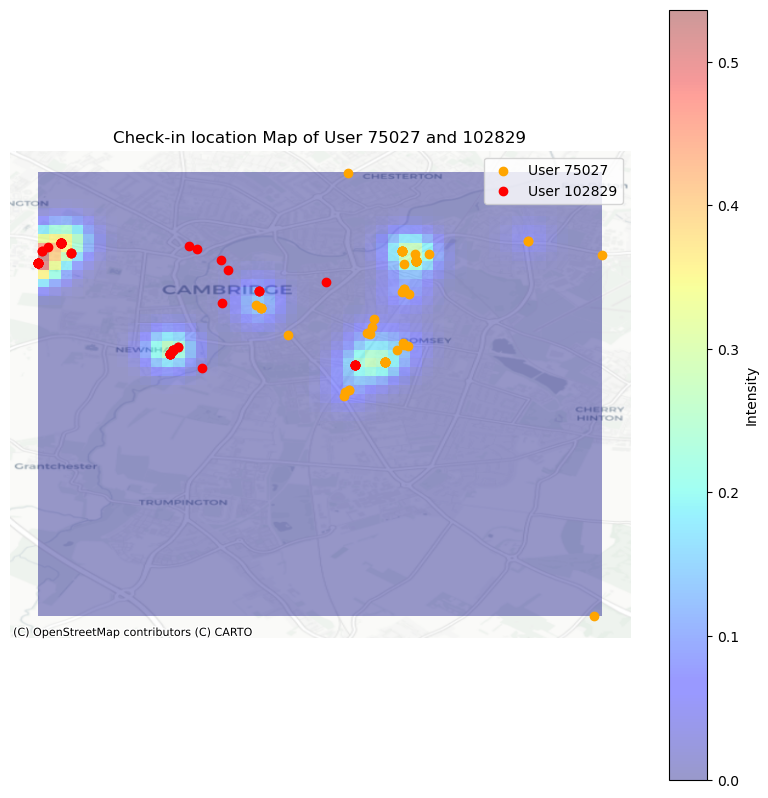

In [72]:
# Define the heatmap function
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet', alpha=0.6):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    return logheatmap, extent

# Create GeoDataFrames for gdf1 and gdf2
gdf1 = gpd.GeoDataFrame(df[df['User_ID'] == 75027], geometry=gpd.points_from_xy(df[df['User_ID'] == 75027].lon, df[df['User_ID'] == 75027].lat))
gdf2 = gpd.GeoDataFrame(df[df['User_ID'] == 102829], geometry=gpd.points_from_xy(df[df['User_ID'] == 102829].lon, df[df['User_ID'] == 102829].lat))

# Set CRS for both GeoDataFrames
gdf1 = gdf1.set_crs(epsg=4326)
gdf2 = gdf2.set_crs(epsg=4326)

# Merge gdf1 and gdf2 into gdfMerge
gdfMerge = gpd.GeoDataFrame(pd.concat([gdf1, gdf2], ignore_index=True))

# Plot both GeoDataFrames and overlay heatmap
fig, ax = plt.subplots(figsize=(10,10))

# Plot gdf1 with blue color
gdf1.plot(ax=ax, color='orange', label='User 75027')

# Plot gdf2 with red color
gdf2.plot(ax=ax, color='red', label='User 102829')

# Add basemap
cx.add_basemap(ax, crs=gdf2.crs.to_string(), source=cx.providers.CartoDB.Positron)

# Generate heatmap for gdfMerge
logheatmap, extent = heatmap(gdfMerge, bins=50, smoothing=1.5, alpha=0.4)

# Overlay heatmap
img = ax.imshow(logheatmap, cmap='jet', extent=extent, alpha=0.4)

# Add color bar
cbar = plt.colorbar(img)
cbar.set_label('Intensity')

# Add legend
plt.axis('off')
plt.legend()
plt.title("Check-in location Map of User 75027 and 102829")

# Show plot
plt.show()


According to the plot, User 75027 and 102829 are assumed to be __students__ as their mobility pattern is concentrated around the University of Cambridge.

### Provide Characterisation of the Gowalla dataset

In [74]:
# Subset user1 (75027) data for the date 30/01/2010
gdf1_filter = gdf1[gdf1['date'] == '30/01/2010']

# Sort the data of user 75027 based on time in ascending order
sorted_gdf1 = gdf1_filter.sort_values(by='Time', ascending=True)

# Display the sorted GeoDataFrame
sorted_gdf1


ID  User_ID        date      Time       lon        lat  loc_ID  \
1227  1228    75027  30/01/2010  15:13:43  0.173005  52.157223  477840   
1226  1227    75027  30/01/2010  16:04:04  0.145606  52.204923   31968   
1225  1226    75027  30/01/2010  16:06:57  0.144522  52.205200  478133   
1224  1225    75027  30/01/2010  16:15:35  0.144826  52.205650  478191   
1223  1224    75027  30/01/2010  16:59:45  0.146594  52.209822  373382   
1222  1223    75027  30/01/2010  17:05:41  0.144786  52.209487  159331   
1221  1222    75027  30/01/2010  17:20:55  0.144424  52.211325  374196   
1220  1221    75027  30/01/2010  21:27:50  0.127612  52.198955   31328   
1219  1220    75027  30/01/2010  22:14:11  0.123643  52.202858  473651   

                      geometry  
1227  POINT (0.17301 52.15722)  
1226  POINT (0.14561 52.20492)  
1225  POINT (0.14452 52.20520)  
1224  POINT (0.14483 52.20565)  
1223  POINT (0.14659 52.20982)  
1222  POINT (0.14479 52.20949)  
1221  POINT (0.14442 52.21132)  
1220  POINT (0.12761 52.19895)  
1219  POINT (0.12364 52.20286)

In [75]:
# Subset user2 (102829) data for the date 24/05/2010
gdf2_filter = gdf2[gdf2['date'] == '24/05/2010']

# Sort the data of user 102829 based on time in ascending order
sorted_gdf2 = gdf2_filter.sort_values(by='Time', ascending=True)

# Display the sorted GeoDataFrame
sorted_gdf2


ID  User_ID        date      Time       lon        lat   loc_ID  \
1375  1376   102829  24/05/2010  10:58:54  0.137495  52.194409    21356   
1374  1375   102829  24/05/2010  12:14:26  0.090578  52.209531   536286   
1373  1374   102829  24/05/2010  14:20:06  0.094001  52.212543   373983   
1372  1373   102829  24/05/2010  17:16:12  0.114811  52.194001  1166464   
1371  1372   102829  24/05/2010  17:33:12  0.117766  52.203666    21357   
1370  1371   102829  24/05/2010  17:49:04  0.117664  52.210026   558662   
1369  1370   102829  24/05/2010  18:46:53  0.118662  52.208558    21375   
1368  1369   102829  24/05/2010  20:34:44  0.110121  52.196113  1024097   

                      geometry  
1375  POINT (0.13750 52.19441)  
1374  POINT (0.09058 52.20953)  
1373  POINT (0.09400 52.21254)  
1372  POINT (0.11481 52.19400)  
1371  POINT (0.11777 52.20367)  
1370  POINT (0.11766 52.21003)  
1369  POINT (0.11866 52.20856)  
1368  POINT (0.11012 52.19611)

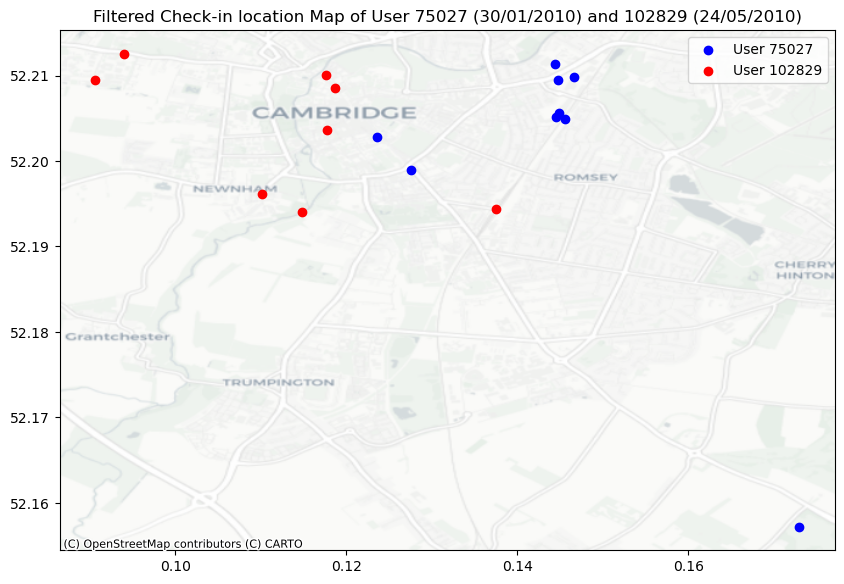

In [76]:
# Plot both GeoDataFrames in one plot with different colors
fig, ax = plt.subplots(figsize=(10, 10))

# Plot sorted_gdf1 with blue color
sorted_gdf1.plot(ax=ax, color='blue', label='User 75027')

# Plot sorted_gdf2 with red color
sorted_gdf2.plot(ax=ax, color='red', label='User 102829')

# Add basemap
cx.add_basemap(ax, crs=gdf2.crs.to_string(), source=cx.providers.CartoDB.Positron)

# Add legend
plt.legend()

# Set plot title
plt.title("Filtered Check-in location Map of User 75027 (30/01/2010) and 102829 (24/05/2010)")

# Show plot
plt.show()


#### Shortest-path Analysis (User 75027)

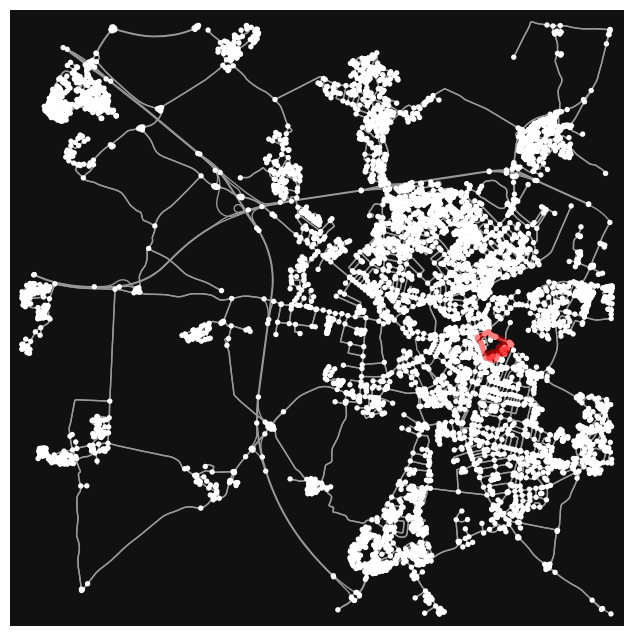

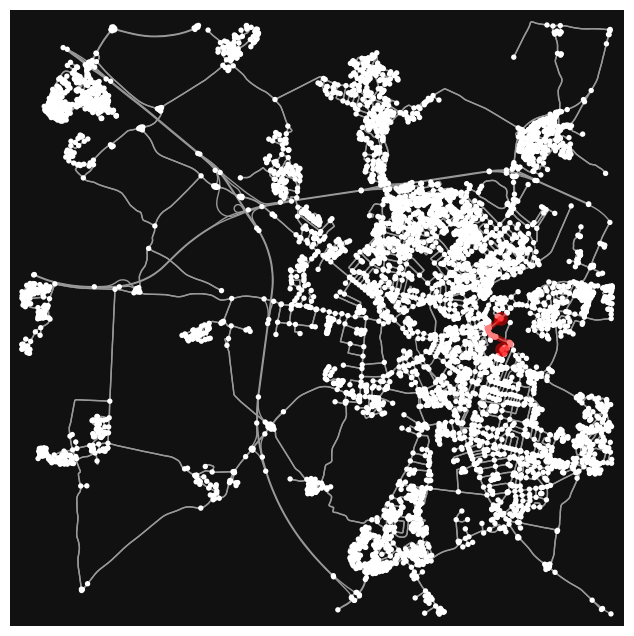

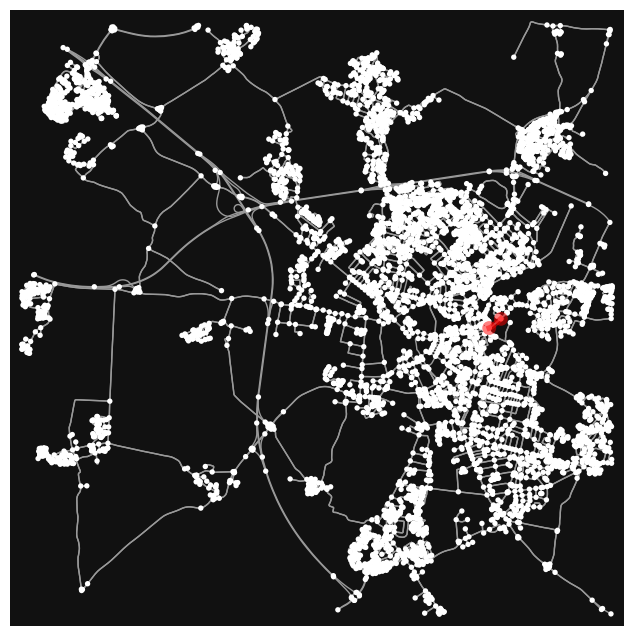

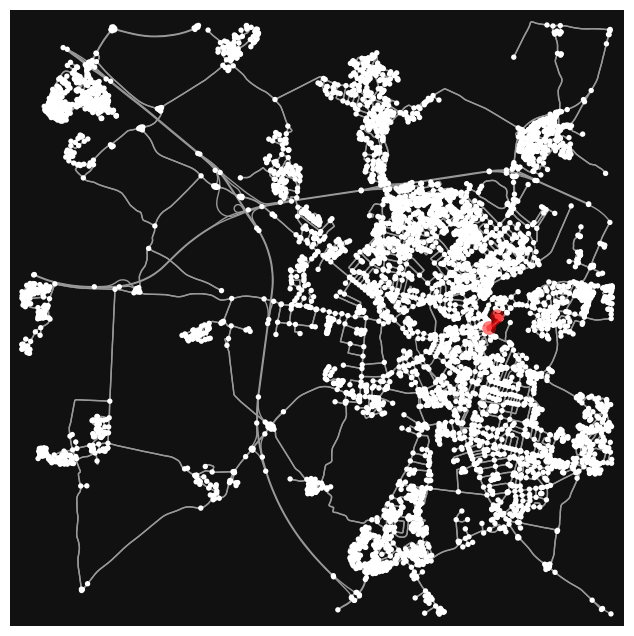

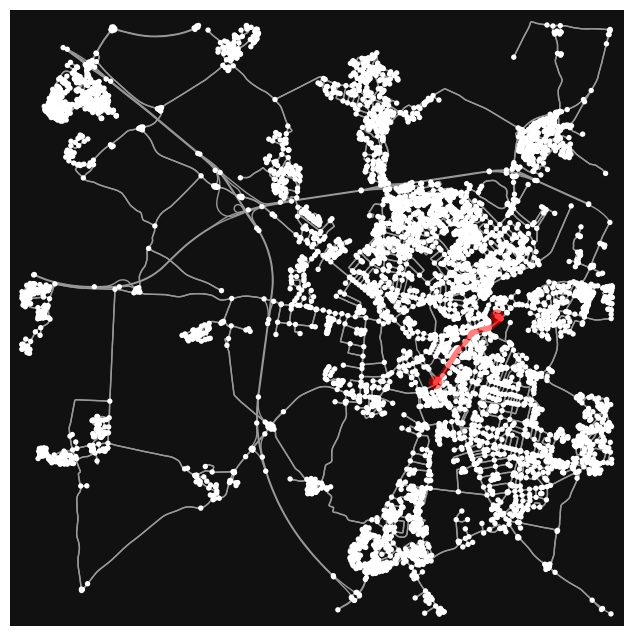

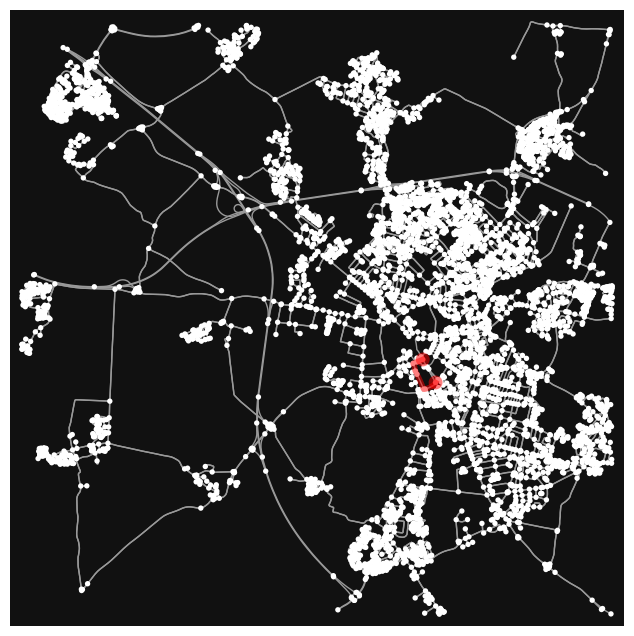

Route lengths: [6982.483000000001, 2093.5480000000007, 1833.4229999999998, 1373.3080000000002, 303.175, 402.351, 2025.003, 1069.021]


In [77]:
# Retrieve the street network graph based on the address 'University of Cambridge, Cambridge'
G = ox.graph_from_address('University of Cambridge, Cambridge', dist=6000, network_type='drive')

# Initialize an empty list to store the concatenated latitude and longitude values
lat_lon_array1 = []

# Iterate over the rows of sorted_gdf1
for index, row in sorted_gdf1.iterrows():
    # Extract latitude and longitude values from each row
    lat = row['lat']
    lon = row['lon']
    # Concatenate latitude and longitude values into a list and append to the list
    lat_lon_array1.append([lat, lon])

# Initialize an empty list to store route lengths
route_lengths1 = []

# Iterate over lat_lon_array1 to calculate shortest distances for each pair of points
for i in range(len(lat_lon_array1) - 1):
    # Define origin and destination points, then get the nodes nearest to each
    origin_point = lat_lon_array1[i] 
    destination_point = lat_lon_array1[i + 1] 
    origin_node = ox.nearest_nodes(G, origin_point[1], origin_point[0])
    destination_node = ox.nearest_nodes(G, destination_point[1], destination_point[0])
    
    # Find the shortest path between origin and destination nodes
    route = nx.shortest_path(G, origin_node, destination_node, weight='length')
    route_length = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
    route_lengths1.append(route_length)
    
    # Plot the route showing origin/destination lat-long points in red
    fig, ax = ox.plot_graph_route(G, route)
    ax.set_title(f"Route {i+1}: Length {route_length} meters")

# Print the route lengths
print("Route lengths:", route_lengths1)


In [78]:
# Characteristics of User 1 (75027)
max1 = max(route_lengths1)
mean1 = sum(route_lengths1) / len(route_lengths1)
sum1 = sum(route_lengths1)

# Results
print("Maximum displacement of User 75027 is", max1, "meters")
print("Average displacement of User 75027 is", mean1, "meters")
print("Total distance travelled on 30-01-2010 by User 75027 is", sum1, "meters")

Maximum displacement of User 75027 is 6982.483000000001 meters
Average displacement of User 75027 is 2010.2890000000004 meters
Total distance travelled on 30-01-2010 by User 75027 is 16082.312000000004 meters


#### Shortest-path Analysis (User 102829)

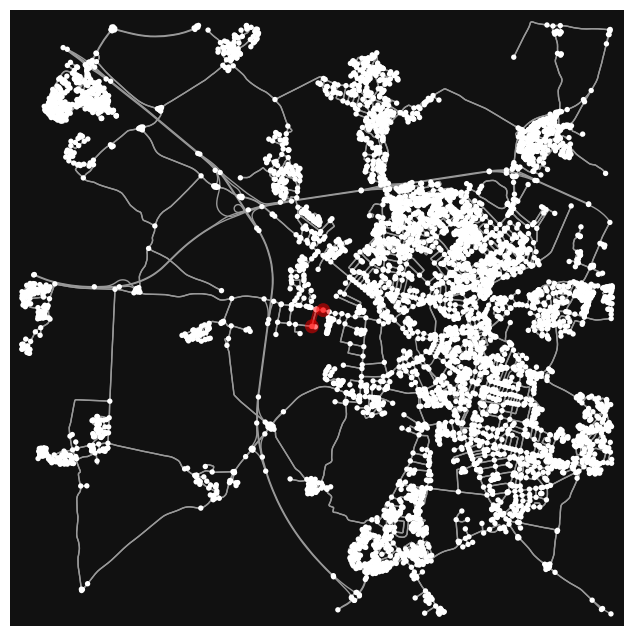

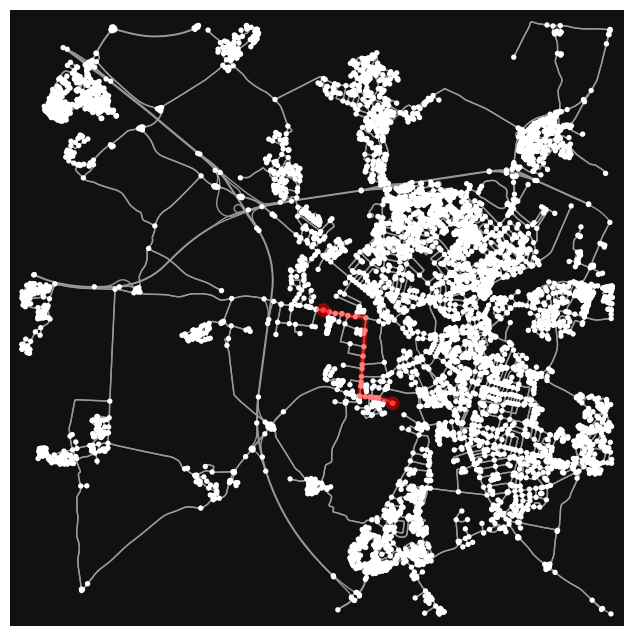

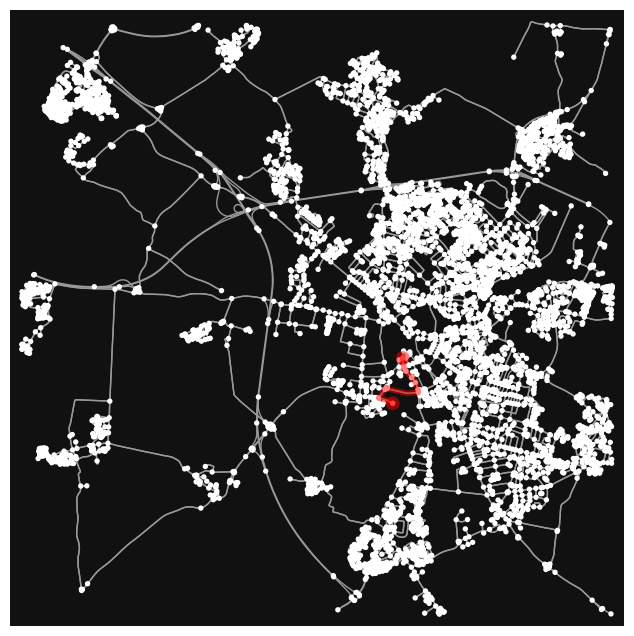

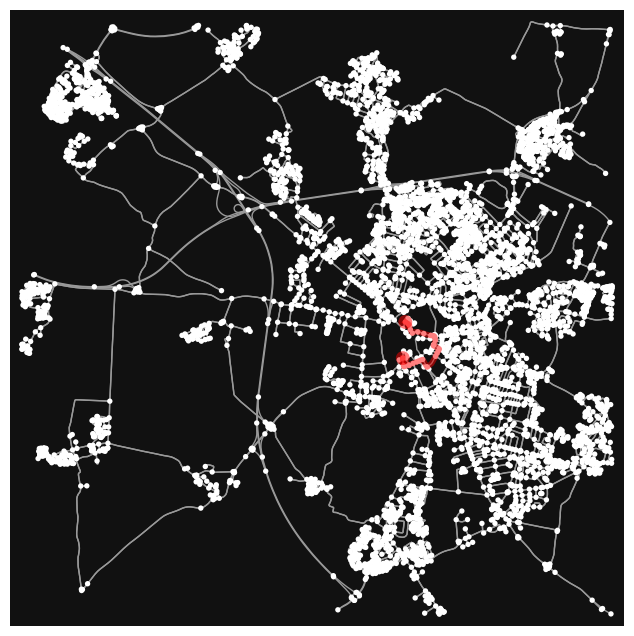

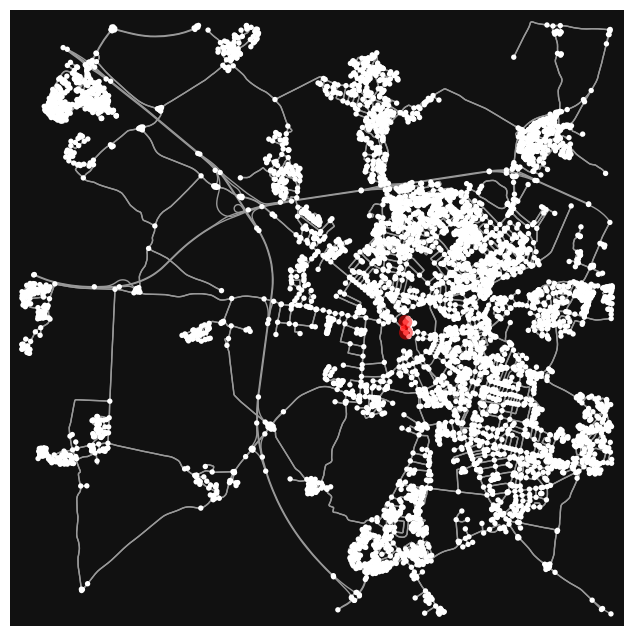

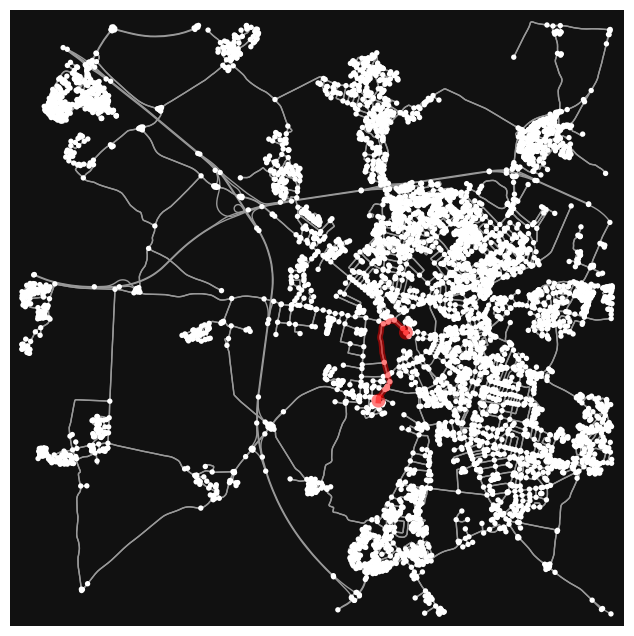

Route lengths: [5023.179999999999, 503.775, 3172.7740000000003, 2049.2940000000003, 2316.471, 248.027, 2290.131]


In [80]:
# Retrieve the street network graph based on the address 'University of Cambridge, Cambridge'
G = ox.graph_from_address('University of Cambridge, Cambridge', dist=6000, network_type='drive')

#----------------------------------------------------------------------------------------

# Initialize an empty list to store the concatenated latitude and longitude values
lat_lon_array2 = []
# Iterate over the rows of sorted_gdf2
for index, row in sorted_gdf2.iterrows():
    # Extract latitude and longitude values from each row
    lat = row['lat']
    lon = row['lon']
    # Concatenate latitude and longitude values into a list and append to the list
    lat_lon_array2.append([lat, lon])

#----------------------------------------------------------------------------------------

# Initialize an empty list to store route lengths
route_lengths2 = []

# Iterate over lat_lon_array2 to calculate shortest distances for each pair of points
for i in range(len(lat_lon_array2) - 1):
    # Define origin/desination points then get the nodes nearest to each
    origin_point = lat_lon_array2[i] 
    destination_point = lat_lon_array2[i + 1] 
    origin_node = ox.nearest_nodes(G, origin_point[1], origin_point[0])
    destination_node = ox.nearest_nodes(G, destination_point[1], destination_point[0])
    
    # Find the shortest path between origin and destination nodes
    route = nx.shortest_path(G, origin_node, destination_node, weight='length')
    route_length = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
    route_lengths2.append(route_length)
    
    # Plot the route showing origin/destination lat-long points in red
    fig, ax = ox.plot_graph_route(G, route)
    ax.set_title(f"Route {i+1}: Length {route_length} meters")

# Print the route lengths
print("Route lengths:", route_lengths2)


In [81]:
# Characteristic of User 2 (102829)
max2 = max(route_lengths2)
mean2 = sum(route_lengths2) / len(route_lengths2)
sum2 = sum(route_lengths2)

# Results
print("Maximum displacement of user 102829 is", max2, "meters")
print("Average displacement of user 102829 is", mean2, "meters")
print("Total distance travelled on 24-05-2010 by user 102829 is", sum2, "meters")


Maximum displacement of user 102829 is 5023.179999999999 meters
Average displacement of user 102829 is 2229.0931428571425 meters
Total distance travelled on 24-05-2010 by user 102829 is 15603.651999999998 meters


User 75027 and 102829 have almost similar mobility characteristics in terms of distance traveled a day, with user 75027 generally traveling a longer distance than user 102829. However, these two users are different in terms of check-in location. User 75027 tends to mobilize in the eastern part of the University of Cambridge, while user 102829 is more in the central and western parts.  

### Urban Planning Application Question - Site Selection for new Restaurants

### Check-in Analysis

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\1752777995.py:14: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\1752777995.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')


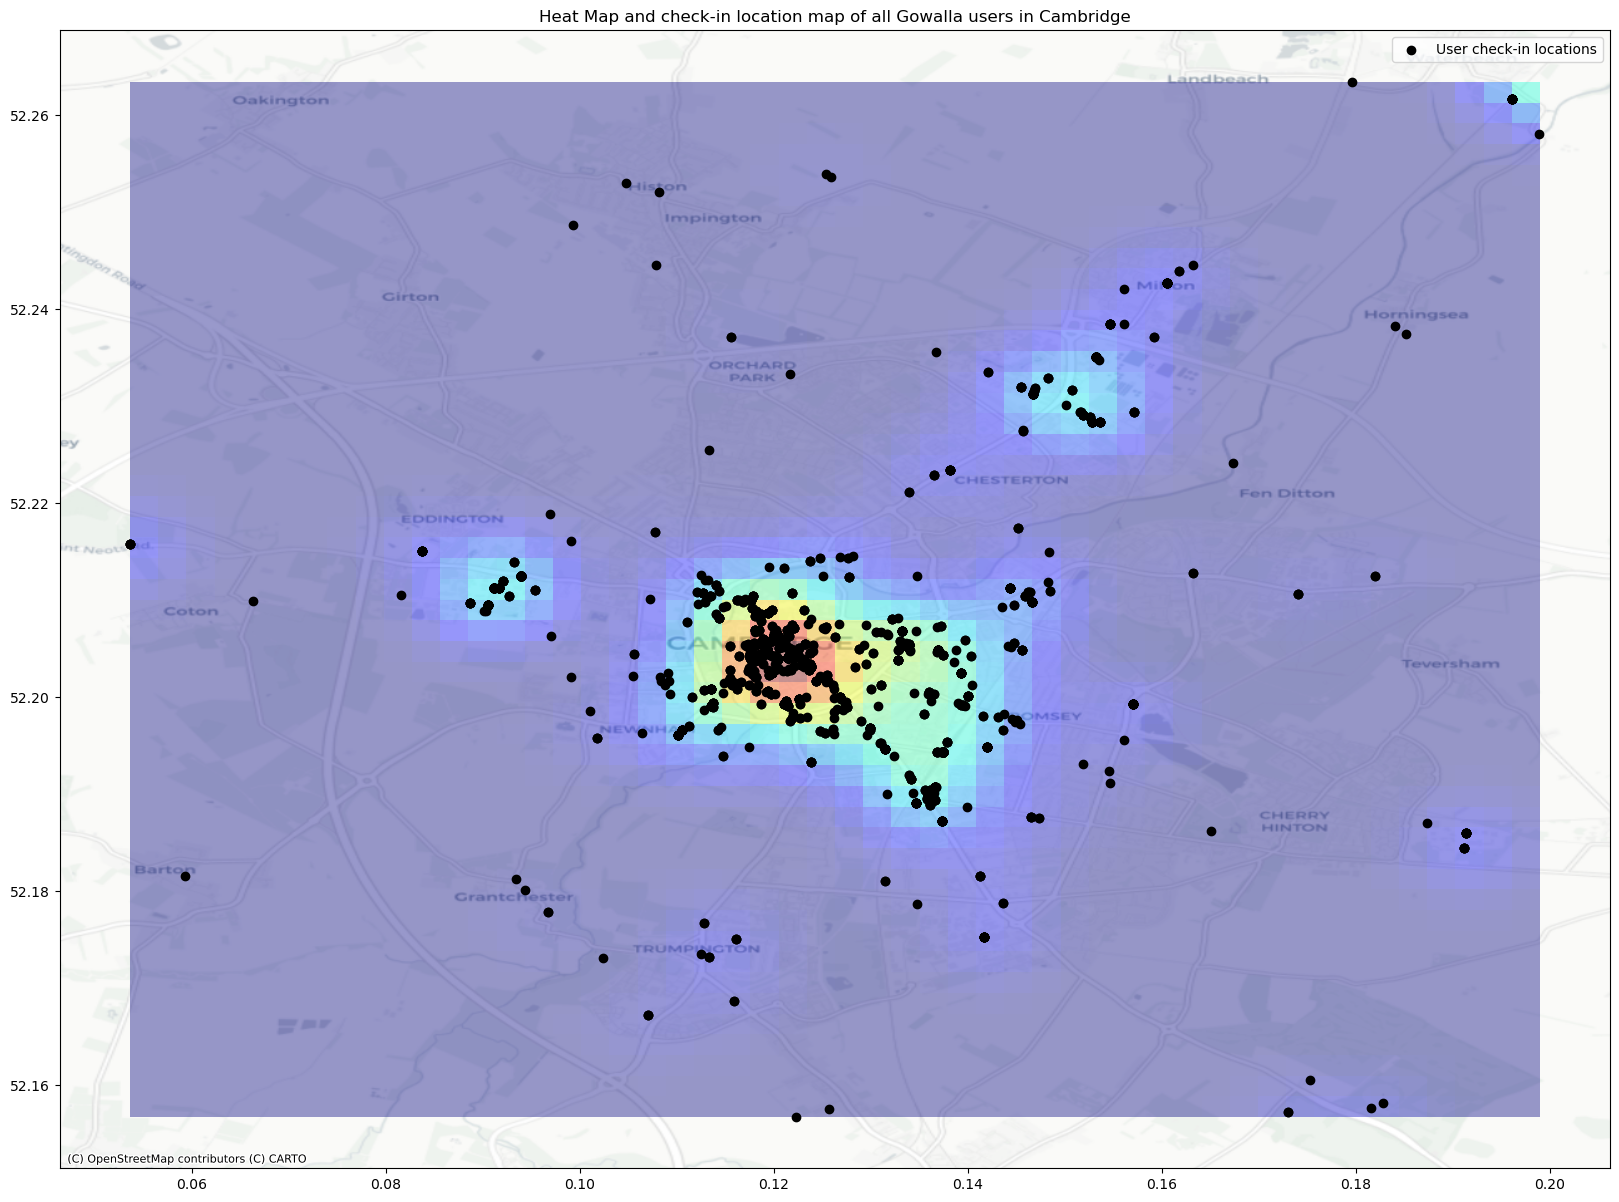

In [97]:
# Create GeoDataFrame for gdf (plotting all user Gowalla Check-in location)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
# Set CRS for the GeoDataFrame
gdf = gdf.set_crs(epsg=4326)

# Plot the GeoDataFrame with the basemap
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')  # Ensure aspect ratio is maintained

# Plot the GeoDataFrame gdf
gdf.plot(ax=ax, color='black', label='User check-in locations')

# Add basemap
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

# Generate heatmap for gdfMerge
logheatmap, extent = heatmap(gdf, bins=50, smoothing=1.5, alpha=0.4)

# Overlay the heatmap on top of the basemap
ax.imshow(logheatmap, cmap='jet', extent=extent, alpha=0.4)

# Add legend
plt.legend()

plt.title("Heat Map and check-in location map of all Gowalla users in Cambridge")
# Show plot
plt.show()


The majority of user mobility patterns is concentrated along St Andrew Street or Regent Street and around the University of Cambridge.

#### Land-Use Mapping

In [82]:
# Retrieve geometries of features near Camden Town, London, UK, based on specified tags
# Convert geometries to Web Mercator projection (EPSG:3857)
tags = {'amenity': True, 'highway': True, 'landuse': True, 'building': True, 'waterway': True, 'railway': True}
all_geom = ox.geometries_from_address('University of Cambridge, Cambridge, UK', tags, dist=6000)
all_geom = all_geom.to_crs(epsg=3857)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\616045324.py:4: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  all_geom = ox.geometries_from_address('University of Cambridge, Cambridge, UK', tags, dist=6000)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6864\3342897369.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


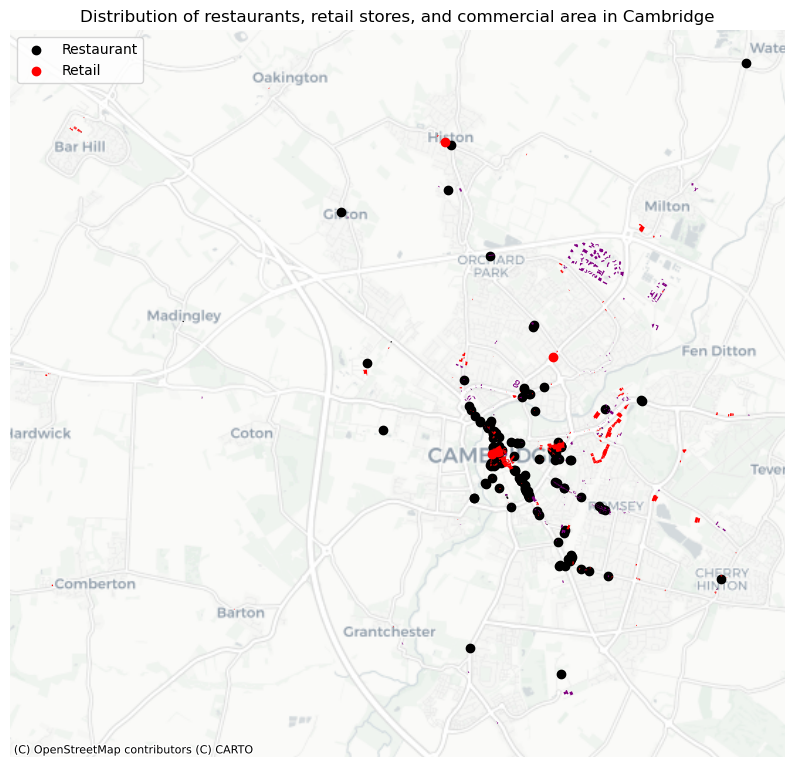

In [83]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot 
all_geom[all_geom['amenity'] == 'restaurant'].plot(ax=ax, color='black', label='Restaurant')
all_geom[all_geom['building'] == 'commercial'].plot(ax=ax, color='purple', label='Commercial')
all_geom[all_geom['building'] == 'retail'].plot(ax=ax, color='red', label='Retail')

# Add basemap using contextily
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Turn off axis
plt.axis('off')
plt.legend()
plt.title("Distribution of restaurants, retail stores, and commercial area in Cambridge")

# Show the plot
plt.show()


The location of commercial buildings and retail stores has a significant impact on the distribution of restaurants in Cambridge. This is because high traffic and human mobility in these areas create a favorable environment for restaurant businesses to thrive. However, the level of influence may vary depending on different location.

#### Network Analysis

In [27]:
# Create a directed graph representation from the retrieved graph
DG = ox.get_digraph(G)

# Calculate closeness centrality for edges in the drive network graph by converting it to a line graph
edge_cc = nx.closeness_centrality(nx.line_graph(DG))

# Calculate betweenness centrality for edges in the drive network graph by converting it to a line graph
edge_bc = nx.betweenness_centrality(nx.line_graph(DG))

# Assign closeness centrality values ('cc') as edge attributes to the drive network graph (DG)
nx.set_edge_attributes(DG, edge_cc,'cc')

# Assign betweenness centrality ('bc') as edge attributes to the drive network graph (DG)
nx.set_edge_attributes(DG, edge_bc,'bc')

# Create a multigraph (WG1) from the directed graph (DG)
WG1 = nx.MultiGraph(DG)

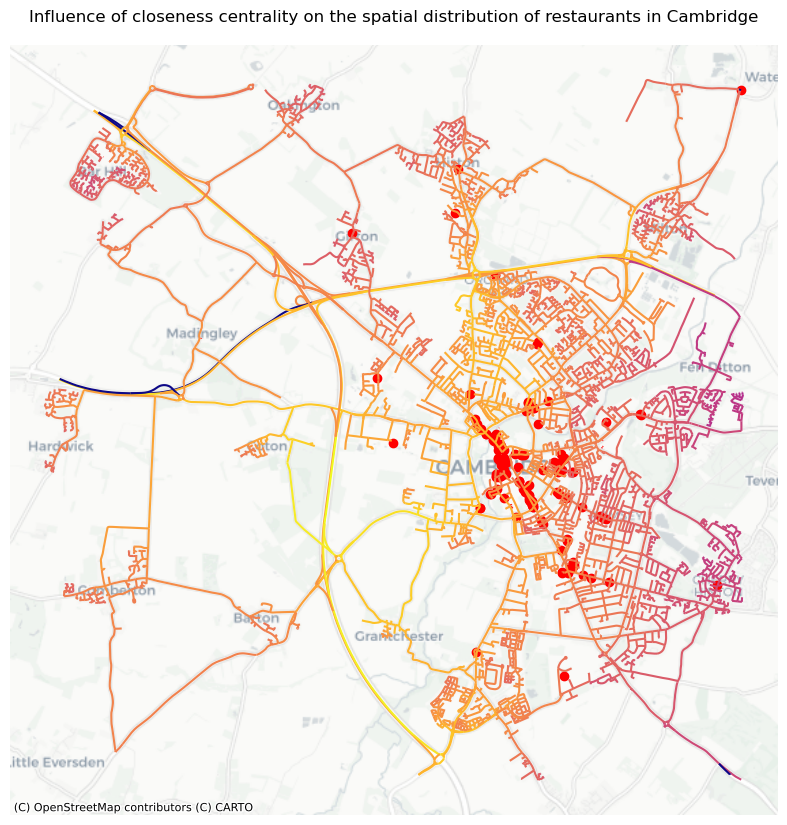

In [84]:
# Combine closeness centrality with restaurant data 
# Visualize the closeness centrality by adding a basemap
# Convert the graph to a GeoPandas dataframe
gdf_edges = ox.graph_to_gdfs(WG1, nodes=False, fill_edge_geometry=True)

# Set the coordinate reference system (CRS) to EPSG:3857 (needed for contextily)
gdf_edges = gdf_edges.to_crs(epsg=3857)

# Plot edges according to closeness centrality
ax = gdf_edges.plot('cc', cmap='plasma', figsize=(10, 10))

# Symbolize all restaurants
all_geom[all_geom['amenity'] == 'restaurant'].plot(ax=ax, color='red')

# Add a basemap using contextily
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.axis('off')
plt.title("Influence of closeness centrality on the spatial distribution of restaurants in Cambridge")
plt.show()

Based on the plot, restaurants tend to be located on medium-centrality roads especially along the St Andrew or Regent street to get sufficient traffic from customers but still not be too busy to avoid traffic jams, which can lead to discomfort for the customers. However, this location generates a good profit as it has good visibility. 

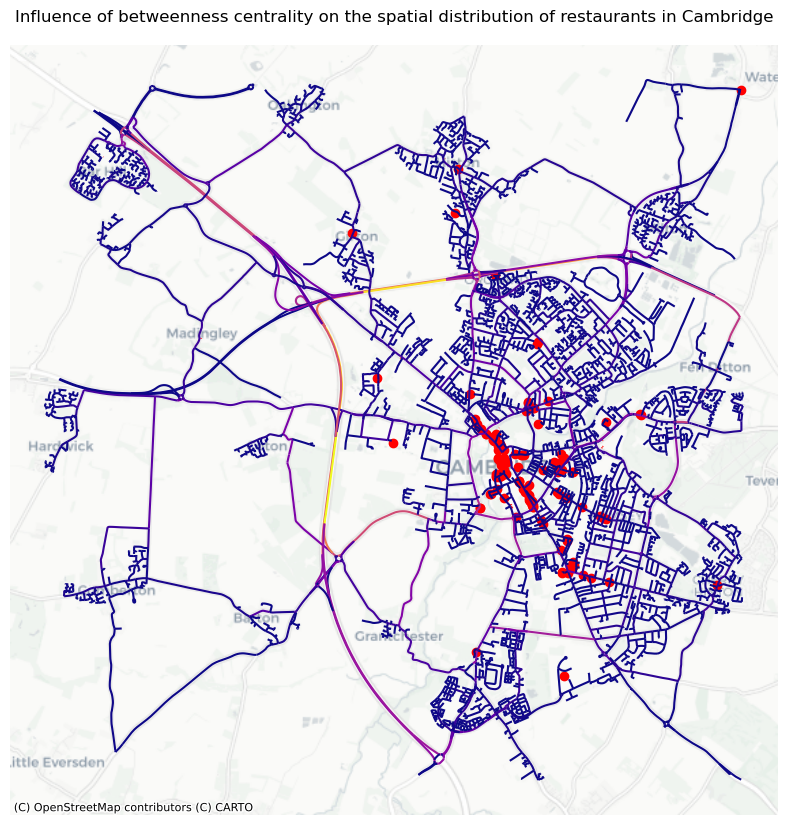

In [85]:
# Combine betweenness centrality with restaurant data 
# Visualize the betweenness centrality by adding a basemap
# Convert the graph to a GeoPandas dataframe
gdf_edges = ox.graph_to_gdfs(WG1, nodes=False, fill_edge_geometry=True)

# Set the coordinate reference system (CRS) to EPSG:3857 (needed for contextily)
gdf_edges = gdf_edges.to_crs(epsg=3857)

# Plot edges according to betweenness centrality
ax = gdf_edges.plot('bc', cmap='plasma', figsize=(10, 10))

# Symbolize all restaurants
all_geom[all_geom['amenity'] == 'restaurant'].plot(ax=ax, color='red')

# Add a basemap using contextily
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.axis('off')
plt.title("Influence of betweenness centrality on the spatial distribution of restaurants in Cambridge")
plt.show()


Interestingly, the majority of restaurants in Calgary are located on low-betweenness centrality roads. This could be due to avoiding traffic jams and reducing pollution in high-betweenness streets, which can cause discomfort to customers. 

### Potential areas for new restaurant

According to the previous plots, the most potential area for a new restaurant would likely be near the University of Cambridge, which is surrounded by retail and commercial areas with medium closeness centrality, and low betweness centrality as all of this information shows a significant effect on the restaurant pattern in Cambridge. These areas have high connectivity and accessibility, making them attractive locations for restaurant owners.

Reference
-------------------------------

(1) Visit Cambridge. Visit Cambridge. [online]. ODI: Cambridge; 2024 [Accessed 23 April 2024]. Available from: https://www.visitcambridge.org/